# Train Low Test Models

This notebook is a streamlined notebook for generating minima of low test accuracy through three different means:
- Dataset Poisoning
- Adding Noise to Data
- Decreasing Dataset Sizes

## Imports

In [1]:
# Standard library
import copy
import os
import sys
import time

# Third-party
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Local package imports
from minima_volume.dataset_funcs import (
    prepare_datasets,
    save_dataset,
    save_model,
)
from minima_volume.train_funcs import evaluate, train

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Input Parameters

In [2]:

# ==============================
# Base Input Parameters
# ==============================
# --- SEEDS ---
data_seed = 7            
model_seed = 7           

# --- Training configuration ---
epochs = 2000            

# --- Dataset configuration ---
base_data_size = 400      
dataset_type = "poison"    
dataset_quantities = [0, 10, 20, 50, 100]

# --- Output configuration ---
base_output_dir = ""     
save_generated_dataset = True   
save_generated_models = True    


## Model + Dataset Specific Code

This is for specific code.

In [3]:
# User specifies the model module name
from minima_volume.models import swiss_model_data as model_module

test_dataset_size = 2000

# Generate dataset
x_base, y_base, x_test, y_test = model_module.get_dataset(
    base_data_size=base_data_size,
    dataset_quantities=dataset_quantities,
    test_dataset_size=test_dataset_size,
    noise=0.3, # default swiss params
    extra_pts=1000,
    dataset_type=dataset_type,
    seed=data_seed
)

# Swiss specific initialization parameters
input_dim = 2
output_dim = 1
hidden_dims = [32]*5

# Grab model
model_template = model_module.get_model(input_dim=input_dim, hidden_dims=hidden_dims, output_dim=output_dim, device=device, seed=model_seed)

# Grab loss and metrics
loss_fn = model_module.get_loss_fn()
other_metrics = model_module.get_additional_metrics()

## Training

We generate the various datasets used to train our models here, before training them. We record the losses, and what each model was trained on.

In [4]:
# ==============================
# Prepare datasets
# ==============================
x_base_train, y_base_train, x_additional, y_additional = prepare_datasets(
    x_base=x_base,
    y_base=y_base,
    dataset_type=dataset_type,
    dataset_quantities=dataset_quantities,
    base_data_size=base_data_size,
    data_seed=data_seed,
    seed_1=None,
    seed_2=None,
)

x_base_train = x_base_train.to(device)
y_base_train = y_base_train.to(device)
x_additional = x_additional.to(device)
y_additional = y_additional.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

# ==============================
# Training loop
# ==============================
all_models = []

for additional_data in dataset_quantities:
    # Assemble training dataset
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    # Initialize model (defined in the model-specific file)
    torch.manual_seed(model_seed)
    model = copy.deepcopy(model_template)
    optimizer = optim.AdamW(model.parameters(), lr=1e-3)
    batch_size = len(x_train)

    # Train model
    train_loss, train_other_metrics, test_loss, test_other_metrics = train(
        model = model,
        x_train = x_train, y_train = y_train,
        x_test = x_test, y_test = y_test,
        loss_fn = loss_fn,
        metrics = other_metrics,
        optimizer = optimizer,
        epochs=epochs,
        batch_size=batch_size,
        verbose_every=100,
    )
    
    # Build dictionary dynamically for additional metrics
    train_metrics_dict = {}
    test_metrics_dict = {}
    if train_other_metrics is not None:
        # train_other_metrics is a list of dicts per epoch
        for metric_name in train_other_metrics[0].keys():  # keys from first epoch
            train_metrics_dict[f"train_{metric_name}"] = [m[metric_name] for m in train_other_metrics]
            test_metrics_dict[f"test_{metric_name}"] = [m[metric_name] for m in test_other_metrics]
    
    # Store results
    trained_model = {
        "model": model,
        "train_loss": train_loss,
        "test_loss": test_loss,
        "additional_data": additional_data,
        "dataset_type": dataset_type,
        **train_metrics_dict,  # dynamically include additional metrics
        **test_metrics_dict,
    }
    
    all_models.append(trained_model)

    print(f"Completed training with {additional_data} additional samples of {dataset_type}")

    # Free memory (important for large GPU datasets)
    del x_train, y_train
    torch.cuda.empty_cache()


Epoch 1/2000: Train Loss 0.6936 | Test Loss 0.6907 | accs Train 0.5075 Test 0.5817


Epoch 100/2000: Train Loss 0.4668 | Test Loss 0.4614 | accs Train 0.7325 Test 0.7342


Epoch 200/2000: Train Loss 0.0253 | Test Loss 0.0516 | accs Train 0.9925 Test 0.9785


Epoch 300/2000: Train Loss 0.0133 | Test Loss 0.0414 | accs Train 0.9925 Test 0.9858


Epoch 400/2000: Train Loss 0.0066 | Test Loss 0.0301 | accs Train 1.0000 Test 0.9918


Epoch 500/2000: Train Loss 0.0016 | Test Loss 0.0237 | accs Train 1.0000 Test 0.9928


Epoch 600/2000: Train Loss 0.0004 | Test Loss 0.0251 | accs Train 1.0000 Test 0.9922


Epoch 700/2000: Train Loss 0.0001 | Test Loss 0.0267 | accs Train 1.0000 Test 0.9925


Epoch 800/2000: Train Loss 0.0001 | Test Loss 0.0284 | accs Train 1.0000 Test 0.9925


Epoch 900/2000: Train Loss 0.0000 | Test Loss 0.0291 | accs Train 1.0000 Test 0.9928


Epoch 1000/2000: Train Loss 0.0000 | Test Loss 0.0297 | accs Train 1.0000 Test 0.9928


Epoch 1100/2000: Train Loss 0.0000 | Test Loss 0.0302 | accs Train 1.0000 Test 0.9928


Epoch 1200/2000: Train Loss 0.0000 | Test Loss 0.0305 | accs Train 1.0000 Test 0.9930


Epoch 1300/2000: Train Loss 0.0000 | Test Loss 0.0307 | accs Train 1.0000 Test 0.9930


Epoch 1400/2000: Train Loss 0.0000 | Test Loss 0.0309 | accs Train 1.0000 Test 0.9930


Epoch 1500/2000: Train Loss 0.0000 | Test Loss 0.0310 | accs Train 1.0000 Test 0.9930


Epoch 1600/2000: Train Loss 0.0000 | Test Loss 0.0311 | accs Train 1.0000 Test 0.9930


Epoch 1700/2000: Train Loss 0.0000 | Test Loss 0.0312 | accs Train 1.0000 Test 0.9932


Epoch 1800/2000: Train Loss 0.0000 | Test Loss 0.0312 | accs Train 1.0000 Test 0.9932


Epoch 1900/2000: Train Loss 0.0000 | Test Loss 0.0313 | accs Train 1.0000 Test 0.9932


Epoch 2000/2000: Train Loss 0.0000 | Test Loss 0.0313 | accs Train 1.0000 Test 0.9932
Completed training with 0 additional samples of poison
Epoch 1/2000: Train Loss 0.6934 | Test Loss 0.6907 | accs Train 0.5098 Test 0.5815


Epoch 100/2000: Train Loss 0.4956 | Test Loss 0.4740 | accs Train 0.7024 Test 0.7208


Epoch 200/2000: Train Loss 0.0945 | Test Loss 0.0772 | accs Train 0.9683 Test 0.9730


Epoch 300/2000: Train Loss 0.0693 | Test Loss 0.0542 | accs Train 0.9732 Test 0.9880


Epoch 400/2000: Train Loss 0.0873 | Test Loss 0.0382 | accs Train 0.9756 Test 0.9908


Epoch 500/2000: Train Loss 0.0510 | Test Loss 0.0431 | accs Train 0.9756 Test 0.9865


Epoch 600/2000: Train Loss 0.0467 | Test Loss 0.0397 | accs Train 0.9780 Test 0.9882


Epoch 700/2000: Train Loss 0.0442 | Test Loss 0.0378 | accs Train 0.9829 Test 0.9878


Epoch 800/2000: Train Loss 0.0418 | Test Loss 0.0393 | accs Train 0.9805 Test 0.9852


Epoch 900/2000: Train Loss 0.0390 | Test Loss 0.0539 | accs Train 0.9829 Test 0.9800


Epoch 1000/2000: Train Loss 0.0362 | Test Loss 0.0415 | accs Train 0.9829 Test 0.9835


Epoch 1100/2000: Train Loss 0.0354 | Test Loss 0.0465 | accs Train 0.9854 Test 0.9805


Epoch 1200/2000: Train Loss 0.0327 | Test Loss 0.0513 | accs Train 0.9878 Test 0.9788


Epoch 1300/2000: Train Loss 0.0321 | Test Loss 0.0539 | accs Train 0.9854 Test 0.9795


Epoch 1400/2000: Train Loss 0.0303 | Test Loss 0.0566 | accs Train 0.9878 Test 0.9790


Epoch 1500/2000: Train Loss 0.0300 | Test Loss 0.0569 | accs Train 0.9854 Test 0.9770


Epoch 1600/2000: Train Loss 0.0290 | Test Loss 0.0609 | accs Train 0.9878 Test 0.9775


Epoch 1700/2000: Train Loss 0.0276 | Test Loss 0.0547 | accs Train 0.9829 Test 0.9812


Epoch 1800/2000: Train Loss 0.0272 | Test Loss 0.0632 | accs Train 0.9854 Test 0.9778


Epoch 1900/2000: Train Loss 0.0254 | Test Loss 0.0742 | accs Train 0.9902 Test 0.9752


Epoch 2000/2000: Train Loss 0.0247 | Test Loss 0.0822 | accs Train 0.9902 Test 0.9738
Completed training with 10 additional samples of poison
Epoch 1/2000: Train Loss 0.6932 | Test Loss 0.6907 | accs Train 0.5167 Test 0.5810


Epoch 100/2000: Train Loss 0.4996 | Test Loss 0.4694 | accs Train 0.7024 Test 0.7318


Epoch 200/2000: Train Loss 0.1548 | Test Loss 0.0977 | accs Train 0.9405 Test 0.9748


Epoch 300/2000: Train Loss 0.1238 | Test Loss 0.0867 | accs Train 0.9476 Test 0.9818


Epoch 400/2000: Train Loss 0.1062 | Test Loss 0.0899 | accs Train 0.9548 Test 0.9768


Epoch 500/2000: Train Loss 0.0918 | Test Loss 0.0914 | accs Train 0.9571 Test 0.9760


Epoch 600/2000: Train Loss 0.0832 | Test Loss 0.0962 | accs Train 0.9595 Test 0.9758


Epoch 700/2000: Train Loss 0.0776 | Test Loss 0.0873 | accs Train 0.9667 Test 0.9785


Epoch 800/2000: Train Loss 0.0737 | Test Loss 0.1029 | accs Train 0.9643 Test 0.9688


Epoch 900/2000: Train Loss 0.0736 | Test Loss 0.1251 | accs Train 0.9714 Test 0.9620


Epoch 1000/2000: Train Loss 0.0689 | Test Loss 0.0949 | accs Train 0.9643 Test 0.9730


Epoch 1100/2000: Train Loss 0.0661 | Test Loss 0.1002 | accs Train 0.9667 Test 0.9730


Epoch 1200/2000: Train Loss 0.0637 | Test Loss 0.1084 | accs Train 0.9667 Test 0.9722


Epoch 1300/2000: Train Loss 0.0607 | Test Loss 0.1166 | accs Train 0.9714 Test 0.9698


Epoch 1400/2000: Train Loss 0.0582 | Test Loss 0.1262 | accs Train 0.9714 Test 0.9660


Epoch 1500/2000: Train Loss 0.0574 | Test Loss 0.1271 | accs Train 0.9738 Test 0.9680


Epoch 1600/2000: Train Loss 0.0552 | Test Loss 0.1412 | accs Train 0.9762 Test 0.9633


Epoch 1700/2000: Train Loss 0.0528 | Test Loss 0.1369 | accs Train 0.9738 Test 0.9630


Epoch 1800/2000: Train Loss 0.0519 | Test Loss 0.1364 | accs Train 0.9714 Test 0.9640


Epoch 1900/2000: Train Loss 0.0516 | Test Loss 0.1534 | accs Train 0.9786 Test 0.9557


Epoch 2000/2000: Train Loss 0.0493 | Test Loss 0.1469 | accs Train 0.9786 Test 0.9600
Completed training with 20 additional samples of poison
Epoch 1/2000: Train Loss 0.6927 | Test Loss 0.6907 | accs Train 0.5244 Test 0.5793


Epoch 100/2000: Train Loss 0.5152 | Test Loss 0.4566 | accs Train 0.7644 Test 0.8165


Epoch 200/2000: Train Loss 0.3023 | Test Loss 0.1642 | accs Train 0.8844 Test 0.9730


Epoch 300/2000: Train Loss 0.2667 | Test Loss 0.1584 | accs Train 0.8911 Test 0.9708


Epoch 400/2000: Train Loss 0.2389 | Test Loss 0.1464 | accs Train 0.9067 Test 0.9610


Epoch 500/2000: Train Loss 0.2163 | Test Loss 0.1683 | accs Train 0.9133 Test 0.9513


Epoch 600/2000: Train Loss 0.2002 | Test Loss 0.2000 | accs Train 0.9222 Test 0.9425


Epoch 700/2000: Train Loss 0.1903 | Test Loss 0.2359 | accs Train 0.9267 Test 0.9307


Epoch 800/2000: Train Loss 0.1648 | Test Loss 0.2496 | accs Train 0.9356 Test 0.9307


Epoch 900/2000: Train Loss 0.1529 | Test Loss 0.2775 | accs Train 0.9356 Test 0.9263


Epoch 1000/2000: Train Loss 0.1487 | Test Loss 0.3086 | accs Train 0.9378 Test 0.9200


Epoch 1100/2000: Train Loss 0.1394 | Test Loss 0.3305 | accs Train 0.9400 Test 0.9183


Epoch 1200/2000: Train Loss 0.1357 | Test Loss 0.3297 | accs Train 0.9422 Test 0.9225


Epoch 1300/2000: Train Loss 0.1301 | Test Loss 0.3644 | accs Train 0.9489 Test 0.9163


Epoch 1400/2000: Train Loss 0.1305 | Test Loss 0.3623 | accs Train 0.9378 Test 0.9215


Epoch 1500/2000: Train Loss 0.1359 | Test Loss 0.3789 | accs Train 0.9333 Test 0.9103


Epoch 1600/2000: Train Loss 0.1235 | Test Loss 0.4089 | accs Train 0.9467 Test 0.9127


Epoch 1700/2000: Train Loss 0.1199 | Test Loss 0.4334 | accs Train 0.9444 Test 0.9103


Epoch 1800/2000: Train Loss 0.1451 | Test Loss 0.3700 | accs Train 0.9244 Test 0.9220


Epoch 1900/2000: Train Loss 0.1150 | Test Loss 0.4271 | accs Train 0.9489 Test 0.9130


Epoch 2000/2000: Train Loss 0.1193 | Test Loss 0.4547 | accs Train 0.9444 Test 0.9103
Completed training with 50 additional samples of poison
Epoch 1/2000: Train Loss 0.6928 | Test Loss 0.6909 | accs Train 0.5140 Test 0.5693


Epoch 100/2000: Train Loss 0.5709 | Test Loss 0.5005 | accs Train 0.7160 Test 0.8033


Epoch 200/2000: Train Loss 0.4373 | Test Loss 0.2713 | accs Train 0.8020 Test 0.9407


Epoch 300/2000: Train Loss 0.4132 | Test Loss 0.2822 | accs Train 0.8180 Test 0.9267


Epoch 400/2000: Train Loss 0.3864 | Test Loss 0.2801 | accs Train 0.8220 Test 0.9227


Epoch 500/2000: Train Loss 0.3600 | Test Loss 0.2899 | accs Train 0.8360 Test 0.9075


Epoch 600/2000: Train Loss 0.3395 | Test Loss 0.3096 | accs Train 0.8460 Test 0.8938


Epoch 700/2000: Train Loss 0.3152 | Test Loss 0.3470 | accs Train 0.8480 Test 0.8895


Epoch 800/2000: Train Loss 0.3112 | Test Loss 0.3514 | accs Train 0.8520 Test 0.8898


Epoch 900/2000: Train Loss 0.3114 | Test Loss 0.3741 | accs Train 0.8620 Test 0.8770


Epoch 1000/2000: Train Loss 0.2754 | Test Loss 0.4337 | accs Train 0.8740 Test 0.8555


Epoch 1100/2000: Train Loss 0.2683 | Test Loss 0.5127 | accs Train 0.8820 Test 0.8275


Epoch 1200/2000: Train Loss 0.2575 | Test Loss 0.4968 | accs Train 0.8880 Test 0.8448


Epoch 1300/2000: Train Loss 0.2516 | Test Loss 0.5213 | accs Train 0.8960 Test 0.8485


Epoch 1400/2000: Train Loss 0.2371 | Test Loss 0.5698 | accs Train 0.9060 Test 0.8357


Epoch 1500/2000: Train Loss 0.2364 | Test Loss 0.6097 | accs Train 0.8920 Test 0.8243


Epoch 1600/2000: Train Loss 0.2226 | Test Loss 0.6274 | accs Train 0.9120 Test 0.8295


Epoch 1700/2000: Train Loss 0.2225 | Test Loss 0.6593 | accs Train 0.9180 Test 0.8270


Epoch 1800/2000: Train Loss 0.2273 | Test Loss 0.6776 | accs Train 0.9080 Test 0.8280


Epoch 1900/2000: Train Loss 0.2172 | Test Loss 0.7559 | accs Train 0.9180 Test 0.7980


Epoch 2000/2000: Train Loss 0.2035 | Test Loss 0.7403 | accs Train 0.9140 Test 0.8193
Completed training with 100 additional samples of poison


## Training Summary

In [5]:
# ====================================
# Summary of Training Results
# ====================================
print("=== True Generalization ===")
for model_data in all_models:
    model = model_data["model"]
    additional_data = model_data["additional_data"]

    test_loss, test_metrics = evaluate(
        model=model,
        x_test=x_test,
        y_test=y_test,
        loss_fn=loss_fn,
        metrics=other_metrics
    )

    metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in test_metrics.items()])
    print(
        f"{additional_data:>4} samples | "
        f"Test Loss: {test_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
    )

print("\n=== Model Diagnostics by Training Data ===")
for additional_data in dataset_quantities:
    # Build dataset with this many additional samples
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    print(f"\nDataset type: {dataset_type}, additional samples: {additional_data}")

    for model_data in all_models:
        model = model_data["model"]
        model_additional_data = model_data["additional_data"]

        train_loss, train_metrics = evaluate(
            model=model,
            x_test=x_train,
            y_test=y_train,
            loss_fn=loss_fn,
            metrics=other_metrics
        )

        metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in train_metrics.items()])
        print(
            f" Model {model_additional_data:>4} | "
            f"Train Loss: {train_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
        )

    # Free memory if large
    del x_train, y_train
    torch.cuda.empty_cache()

=== True Generalization ===
   0 samples | Test Loss: 0.0313 | accs: 0.9932
  10 samples | Test Loss: 0.0822 | accs: 0.9738
  20 samples | Test Loss: 0.1469 | accs: 0.9600
  50 samples | Test Loss: 0.4547 | accs: 0.9103
 100 samples | Test Loss: 0.7403 | accs: 0.8193

=== Model Diagnostics by Training Data ===

Dataset type: poison, additional samples: 0
 Model    0 | Train Loss: 0.0000 | accs: 1.0000
 Model   10 | Train Loss: 0.0132 | accs: 0.9950
 Model   20 | Train Loss: 0.0241 | accs: 0.9875
 Model   50 | Train Loss: 0.0478 | accs: 0.9950
 Model  100 | Train Loss: 0.1065 | accs: 0.9850

Dataset type: poison, additional samples: 10
 Model    0 | Train Loss: 0.3643 | accs: 0.9756
 Model   10 | Train Loss: 0.0249 | accs: 0.9902
 Model   20 | Train Loss: 0.0383 | accs: 0.9732
 Model   50 | Train Loss: 0.0661 | accs: 0.9780
 Model  100 | Train Loss: 0.1285 | accs: 0.9707

Dataset type: poison, additional samples: 20
 Model    0 | Train Loss: 0.6946 | accs: 0.9548
 Model   10 | Train Los

### Model + Data Specific Verification

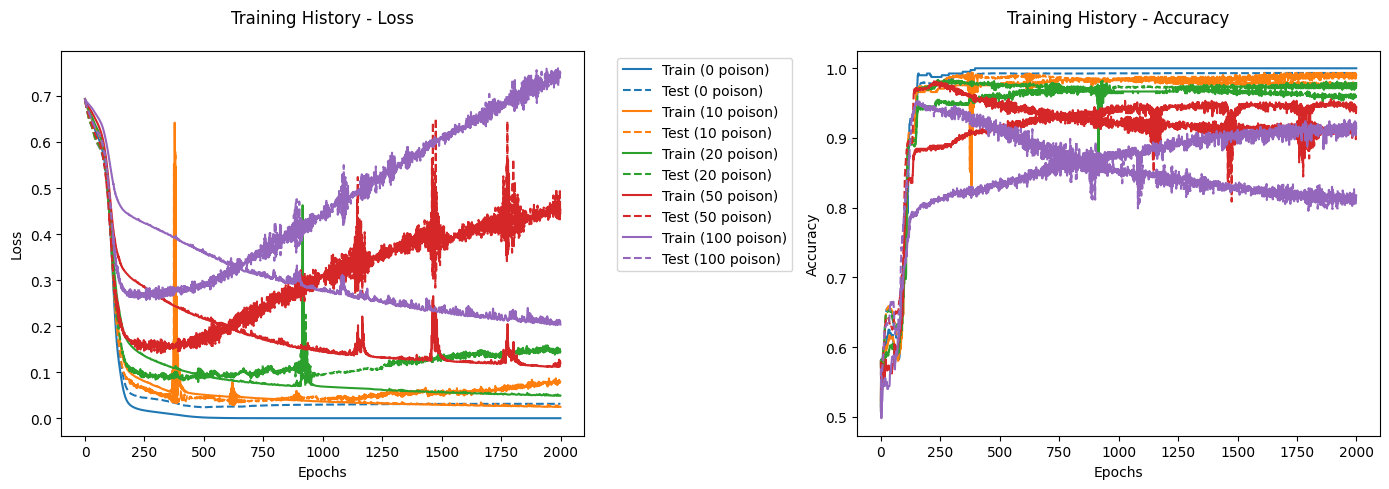

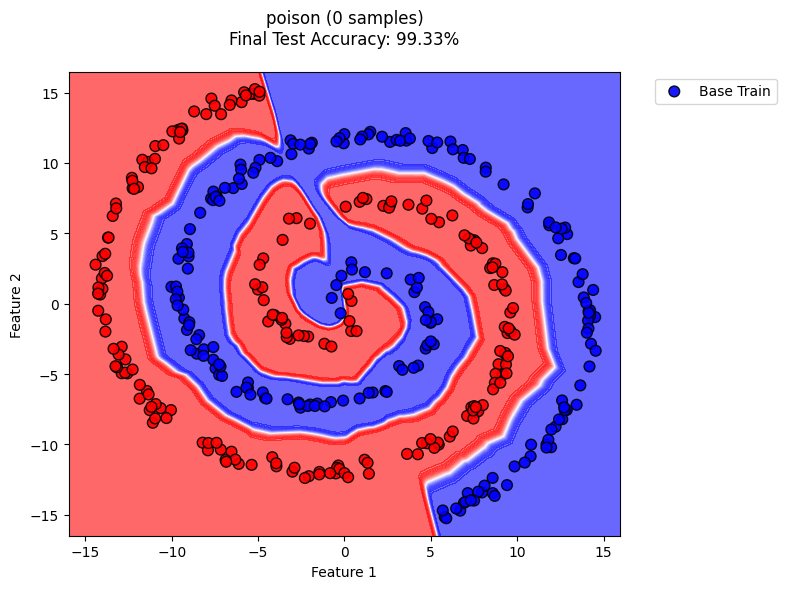

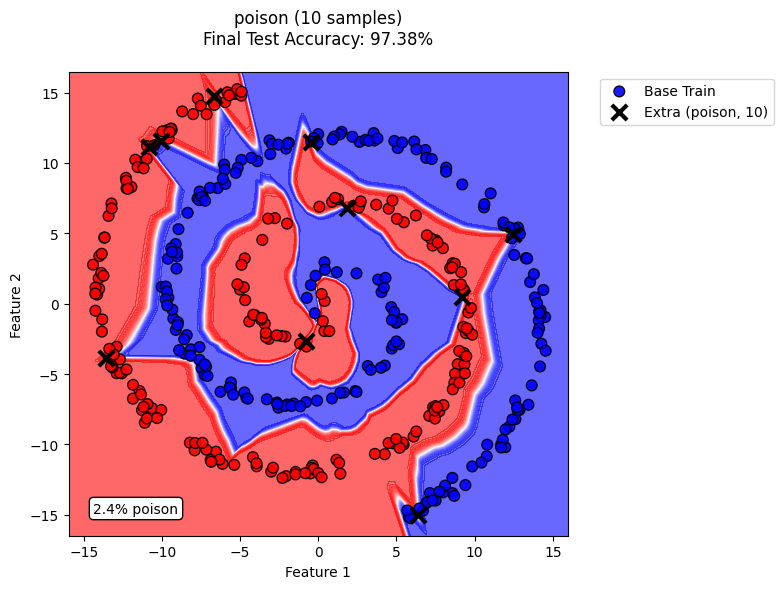

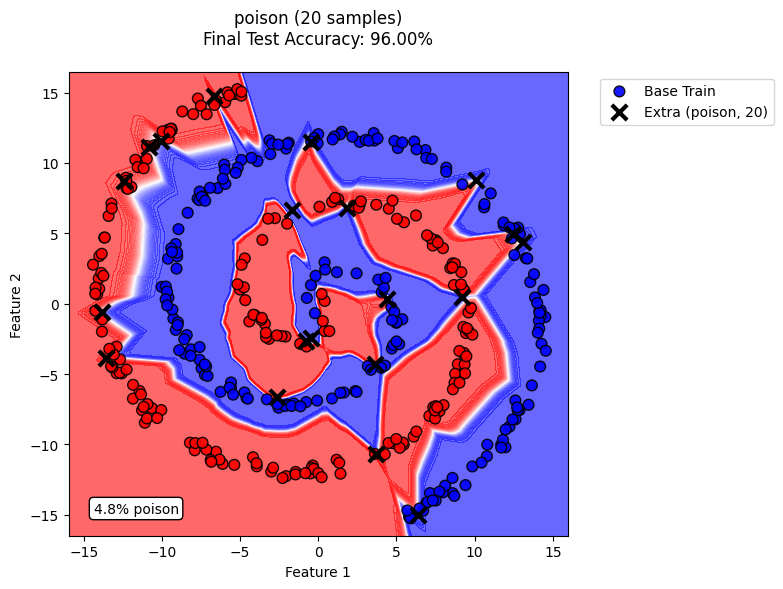

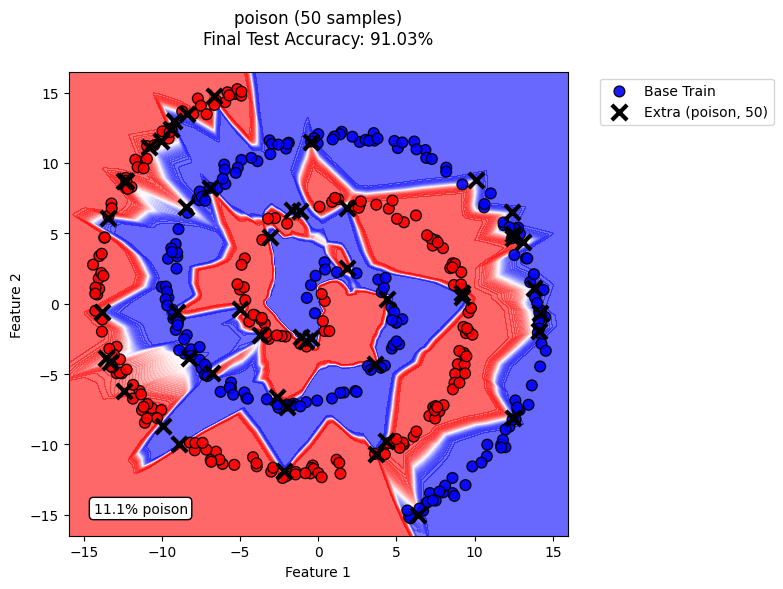

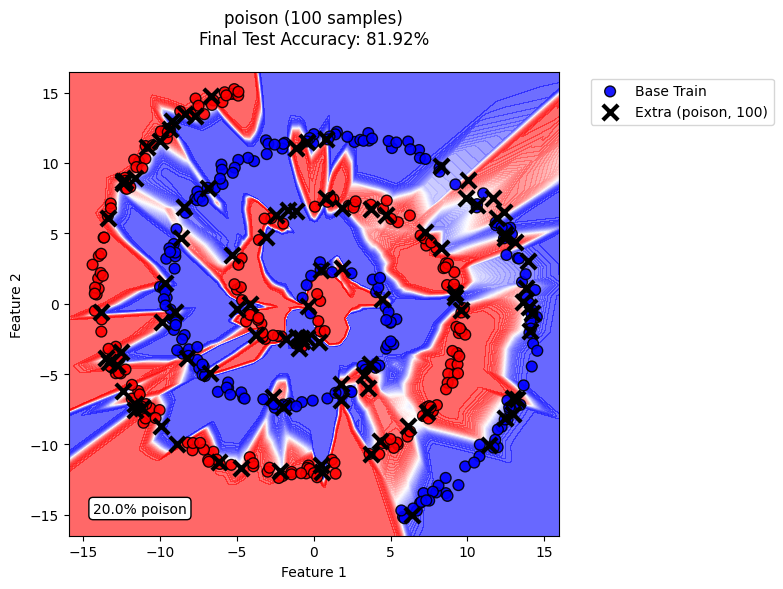

In [6]:
model_module.verify_model_results(
    all_models=all_models,
    x_base_train=x_base_train,
    y_base_train=y_base_train,
    x_additional=x_additional,
    y_additional=y_additional,
    x_test=x_test,
    y_test=y_test,
    dataset_quantities=dataset_quantities,
    dataset_type=dataset_type,
)

## Model Saving

In [7]:
# ====================================
# Save Datasets and Models
# ====================================
output_folder = "models_and_data"
# Save dataset (Possible to skip)
if save_generated_dataset:
    save_dataset(
        folder=output_folder,
        filename="dataset.pt",
        x_base_train=x_base_train,
        y_base_train=y_base_train,
        x_additional=x_additional,
        y_additional=y_additional,
        x_test=x_test,
        y_test=y_test,
        dataset_quantities=dataset_quantities,
        dataset_type=dataset_type,
    )
    print(f"Saved dataset to {output_folder}/dataset.pt")

# Save trained models
if save_generated_models:
    for model_data in all_models:
        filename = f"model_additional_{model_data['additional_data']}.pt"
        save_model(
            folder=output_folder,
            filename=filename,
            model=model_data["model"],
            train_loss=model_data["train_loss"],
            train_accs=model_data["train_accs"],
            test_loss=model_data["test_loss"],
            test_accs=model_data["test_accs"],
            additional_data=model_data["additional_data"],
            dataset_type=model_data["dataset_type"],
        )
        print(f"Saved model: {output_folder}/{filename}")

✅ Dataset saved to models_and_data\dataset.pt
Saved dataset to models_and_data/dataset.pt
✅ Model saved to models_and_data\model_additional_0.pt
Saved model: models_and_data/model_additional_0.pt
✅ Model saved to models_and_data\model_additional_10.pt
Saved model: models_and_data/model_additional_10.pt
✅ Model saved to models_and_data\model_additional_20.pt
Saved model: models_and_data/model_additional_20.pt
✅ Model saved to models_and_data\model_additional_50.pt
Saved model: models_and_data/model_additional_50.pt
✅ Model saved to models_and_data\model_additional_100.pt
Saved model: models_and_data/model_additional_100.pt
